## Prepare Data ##

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import math

# Model Parameters
training_batch_size = 16
num_epochs = 30

# Training / Validation Dataset
class SimulatorDataset(Dataset):
    """Simulator Data Dataset with normalization."""
    def __init__(self, csv_file, root_dir, transform=None):
        self.params_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Get feature data
        self.features = self.params_frame.loc[:, "ROB Size":"CPU Fetch Width"].values
        
        # Normalize the label data
        self.label_scaler = MinMaxScaler()
        target = self.params_frame.loc[:, "Number of Cycles":"Power"].values
        self.normalized_target = self.label_scaler.fit_transform(target)
    
    def __len__(self):
        return len(self.params_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.features[idx]
        target = self.normalized_target[idx]

        # Re-encode data
        one_hot_data = []

        # Encode ROB entries
        num_rob_entries = data[0]
        match num_rob_entries:
            case 16:
                one_hot_data.extend([1, 0, 0, 0, 0, 0, 0])
            case 32:
                one_hot_data.extend([0, 1, 0, 0, 0, 0, 0])
            case 64:
                one_hot_data.extend([0, 0, 1, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 0, 0, 1, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 0, 0, 1, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 0, 0, 1, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError
        
        # Encode IQ entries
        num_iq_entries = data[1]
        match num_iq_entries:
            case 16:
                one_hot_data.extend([1, 0, 0, 0, 0, 0, 0])
            case 32:
                one_hot_data.extend([0, 1, 0, 0, 0, 0, 0])
            case 64:
                one_hot_data.extend([0, 0, 1, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 0, 0, 1, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 0, 0, 1, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 0, 0, 1, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError
        
        # Encode LQ entries
        num_lq_entries = data[2]
        match num_lq_entries:
            case 16:
                one_hot_data.extend([1, 0, 0, 0, 0, 0])
            case 64:
                one_hot_data.extend([0, 1, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 0, 1, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 0, 1, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 0, 1, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError
        
        # Encode SQ entries
        num_sq_entries = data[3]
        match num_sq_entries:
            case 16:
                one_hot_data.extend([1, 0, 0, 0, 0, 0])
            case 64:
                one_hot_data.extend([0, 1, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 0, 1, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 0, 1, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 0, 1, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError
        
        # Encode phys regs
        num_phys_reg = data[4]
        match num_phys_reg:
            case 64:
                one_hot_data.extend([1, 0, 0, 0, 0, 0])
            case 128:
                one_hot_data.extend([0, 1, 0, 0, 0, 0])
            case 256:
                one_hot_data.extend([0, 0, 1, 0, 0, 0])
            case 512:
                one_hot_data.extend([0, 0, 0, 1, 0, 0])
            case 1024:
                one_hot_data.extend([0, 0, 0, 0, 1, 0])
            case 2048:
                one_hot_data.extend([0, 0, 0, 0, 0, 1])
            case _:
                raise NotImplementedError

        # Encode cpu width
        cpu_width = data[5]
        match cpu_width:
            case 2:
                one_hot_data.extend([1, 0, 0, 0])
            case 4:
                one_hot_data.extend([0, 1, 0, 0])
            case 6:
                one_hot_data.extend([0, 0, 1, 0])
            case 8:
                one_hot_data.extend([0, 0, 0, 1])
            case _:
                raise NotImplementedError

        # Pad target to make it equal to data in size for invertiblity
        # Should be size 36
        target2 = np.append(target, target)
        target4 = np.append(target2, target2)
        target8 = np.append(target4, target4)
        target = np.append(target8, target8)
        target = np.append(target, target2)
        sample = {'data': np.array(one_hot_data), 'target': target}
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

# Get dataset
sim_dataset = SimulatorDataset(csv_file='./modified_example.csv', root_dir='.',transform=None)

# Split into training and validation data (3 : 1 split)
val_dataset_size = len(sim_dataset) // 4
train_dataset_size = len(sim_dataset) - val_dataset_size
train_set, val_set = torch.utils.data.random_split(sim_dataset, [train_dataset_size, val_dataset_size])

# Prepare data loader
train_loader = DataLoader(train_set, batch_size=training_batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=training_batch_size, shuffle=True)

## Forward Training ##

In [6]:
# Define MLP
class InvertibleMLP(nn.Module):
    def __init__(self):
        super(InvertibleMLP, self).__init__()
        self.layer1 = nn.Linear(36, 36)
        # self.tanh = nn.Tanh()
        # self.layer2 = nn.Linear(36, 36)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer1(x)
        # x = self.tanh(x)
        # x = self.layer2(x)
        x = self.sigmoid(x)
        return x

    def reverse_mlp(self, x):

        # Info about reversing linear layer from
        # https://stackoverflow.com/questions/59878319/can-you-reverse-a-pytorch-neural-network-and-activate-the-inputs-from-the-output

        # Reverse sigmoid layer
        x = torch.log(x / (1 - x))

        # # Reverse linear layer 2
        # x = x - self.layer2.bias[None, ...]           # Reverse bias
        # x = x[..., None]                              # Convert to column vectors
        # x = torch.linalg.solve(self.layer2.weight, x) # Invert matrix
        # x = torch.squeeze(x)                          # Remove extra dimension added for torch.linalg.solve
        # x = torch.clamp(x, min=-0.9999, max=0.9999)   # Clamp outputs to prevent errors from non linear functions

        # # Reverse tanh layer
        # x = 0.5 * torch.log((1 + x) / (1 - x))

        # Reverse linear layer 1
        x = x - self.layer1.bias[None, ...]           # Reverse bias
        x = x[..., None]                              # Convert to column vectors
        x = torch.linalg.solve(self.layer1.weight, x) # Invert matrix
        x = torch.squeeze(x)                          # Remove extra dimension added for torch.linalg.solve
        x = torch.clamp(x, min=0, max=1)   # Clamp final output to valid inputs

        return x

# Initialize the model
model = InvertibleMLP()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track training and validation loss per epoch
train_losses = []
val_losses = []
val_inverse_losses = []

# Get initial losses

# Training loss
train_loss = count = 0
for i, batch in enumerate(train_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass
    outputs = model(data)
    loss = criterion(outputs, target)
    # Update training accuracy
    train_loss += loss
    count += 1
# Get final epoch train loss
train_loss = train_loss / count
train_losses.append(train_loss.detach().numpy())

# Val loss
val_loss = count = 0
for i, batch in enumerate(val_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Forward pass
    outputs = model(data)
    # Parse output and targets (we only care about first 2 points)
    outputs = outputs[:,0:2]
    target = target[:,0:2]
    # Calculate loss
    loss = criterion(outputs, target)
    # Update validation accuracy
    val_loss += loss
    count += 1
# Get final epoch validation loss
val_loss = val_loss / count
val_losses.append(val_loss.detach().numpy())

# Val inverse loss
val_inverse_loss = count = 0
for i, batch in enumerate(val_loader):
    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()
    # Get inverse
    predicted_param = model.reverse_mlp(target)
    # Calculate loss
    loss = criterion(predicted_param, data).detach().numpy()
    # Update statistics
    # We ignore all nan
    if not math.isnan(loss):
        val_inverse_loss += loss
        count += 1
# Get final epoch inverse validation loss
val_inverse_loss = val_inverse_loss / count
val_inverse_losses.append(val_inverse_loss)

# Train the model
for epoch in range(num_epochs):

    # Report training accuracy
    train_loss = count = 0

    for i, batch in enumerate(train_loader):
        # free the gradient from the previous batch
        optimizer.zero_grad()

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # model backward
        loss.backward()
        # update the model paramters
        optimizer.step()

        # Update training accuracy
        train_loss += loss
        count += 1

    # Get final epoch train loss
    train_loss = train_loss / count
    train_losses.append(train_loss.detach().numpy())

    # Report validation accuracy
    val_loss = count = 0

    # Get validation loss (we only actually care about first 2 data points)
    for i, batch in enumerate(val_loader):

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()
        
        # Forward pass
        outputs = model(data)

        # Parse output and targets (we only care about first 2 points)
        outputs = outputs[:,0:2]
        target = target[:,0:2]

        # Calculate loss
        loss = criterion(outputs, target)

        # Update validation accuracy
        val_loss += loss
        count += 1
    
    # Get final epoch validation loss
    val_loss = val_loss / count
    val_losses.append(val_loss.detach().numpy())

    # Report inverse loss on validation dataset
    val_inverse_loss = count = 0

    # Get inverse loss (we only actually care about first 6 data points)
    for i, batch in enumerate(val_loader):

        # get data and target
        data = batch['data'].float()
        target = batch['target'].float()

        # Get inverse
        predicted_param = model.reverse_mlp(target)

        # Calculate loss
        loss = criterion(predicted_param, data).detach().numpy()

        # Update statistics
        # We ignore all nan
        if not math.isnan(loss):
            val_inverse_loss += loss
            count += 1
    
    # Get final epoch inverse validation loss
    val_inverse_loss = val_inverse_loss / count
    val_inverse_losses.append(val_inverse_loss)

    # Print status check
    print(f"Epoch: [{epoch+1}/{num_epochs}], train_loss: {train_loss}, val_loss: {val_loss}, val_inverse_loss: {val_inverse_loss}")

Epoch: [1/30], train_loss: 0.04119982197880745, val_loss: 0.029334599152207375, val_inverse_loss: 0.4896827078316791
Epoch: [2/30], train_loss: 0.023884329944849014, val_loss: 0.02191372960805893, val_inverse_loss: 0.4513225454294277
Epoch: [3/30], train_loss: 0.01981928199529648, val_loss: 0.0190447848290205, val_inverse_loss: 0.5103768154800651
Epoch: [4/30], train_loss: 0.01802888698875904, val_loss: 0.017661765217781067, val_inverse_loss: 0.4856248105952364
Epoch: [5/30], train_loss: 0.01725398376584053, val_loss: 0.017132334411144257, val_inverse_loss: 0.3922439887970983
Epoch: [6/30], train_loss: 0.01695157028734684, val_loss: 0.0169061366468668, val_inverse_loss: 0.4040596456641695
Epoch: [7/30], train_loss: 0.016862627118825912, val_loss: 0.01690397970378399, val_inverse_loss: 0.35817838720456807
Epoch: [8/30], train_loss: 0.01683144085109234, val_loss: 0.016891295090317726, val_inverse_loss: 0.36322138944785753
Epoch: [9/30], train_loss: 0.016826428472995758, val_loss: 0.01686

### Report Training Statistics ###

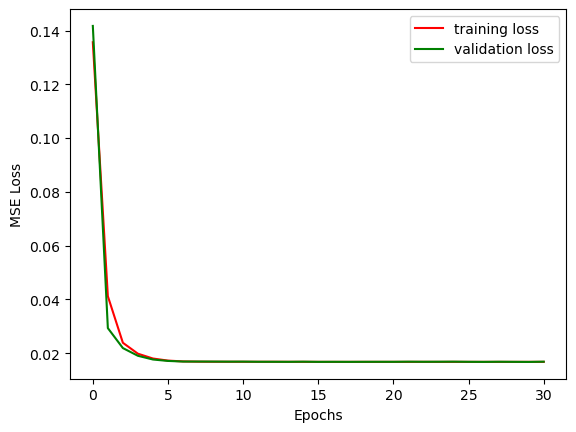

Final validation loss: 0.016856800764799118


In [8]:
# Get x axis
x_data = [x for x in range(num_epochs + 1)]

# Plot data
plt.plot(x_data, train_losses, c='r', label="training loss")
plt.plot(x_data, val_losses, c='g', label="validation loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

# Report final data
print(f"Final validation loss: {val_losses[-1]}")

### Report Final Invert Statistics ###

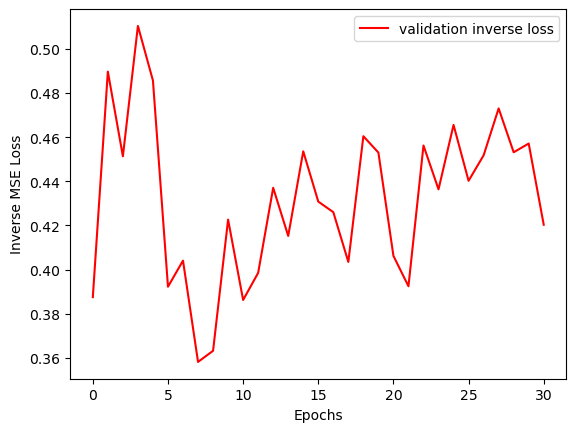

Inverse val loss: 0.3908811157076781
Usable predictions: 93.66852886405958%


In [9]:
# Plot inverse
plt.plot(x_data, val_inverse_losses, c='r', label="validation inverse loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Inverse MSE Loss')
plt.show()

# Report inverse loss
val_inverse_loss = count = 0
valid_predictions = 0

# Get inverse loss (we only actually care about first 6 data points)
for i, batch in enumerate(val_loader):

    # get data and target
    data = batch['data'].float()
    target = batch['target'].float()

    # Get forward
    output = model.forward(data)

    # Get inverse
    predicted_param = model.reverse_mlp(target)

    # Parse data and prediction (we only care about first 6 points)
    data = data[:,0:6]
    predicted_param = predicted_param[:,0:6]

    # Calculate loss
    loss = criterion(predicted_param, data).detach().numpy()

    # Update statistics
    count += 1
    # print(predicted_param)
    # print(data)
    if not math.isnan(loss):
        val_inverse_loss += loss
        valid_predictions += 1

# Get final inverse validation loss
val_inverse_loss = val_inverse_loss / valid_predictions
print(f"Inverse val loss: {val_inverse_loss}")
# Print usuable predictions
usable_pred_percent = valid_predictions / count * 100
print(f"Usable predictions: {usable_pred_percent}%")